# Fast Food Chains and Price Discrimination

Author: Dr. Elaina A. Hyde

---

This group lab uses a 1994 dataset that has detailed prices on items sold at over 400 Burger King, Wendy's, KFC and [Roy Roger](https://en.wikipedia.org/wiki/Roy_Rogers_Restaurants) restaurants in New Jersey and Pennsivania.

It is a restricted version of the dataset used in this publication:

> [K. Graddy (1997), "Do Fast-Food Chains Price Discriminate on the Race and Income Characteristics of an Area?" Journal of Business and Economic Statistics 15, 391-401.](http://people.brandeis.edu/~kgraddy/published%20papers/GraddyK_jbes1997.pdf)

**The goal of this this exercise is to evaluate whether fast-food restaurants are using discriminatory pricing.** This is a fairly open ended prompt and it up to you how you want to quantify pricing discrimination. There are two immediate groups of variables that can help you investigate this:
- You have the prices of items, which can be a metric of discriminatory practices (charging higher prices).
- You have proportion of African Americans, proportion of low income, and proportion of residents without a car.

---

### In groups, you should:
1. **Load the data and examine it.**
2. **Perform any required data cleaning.**
3. **Conduct EDA relevant to the goals of the project.** What variables are you interested in for your target(s) and predictors? What kinds of relationships to you see in the data that will inform your analysis?
4. **Formulate your hypotheses and formally define them.** Come up with a plan, based on the prompt and your EDA, for testing your hypotheses.
5. **Construct regression models to test your hypotheses.** What do you find? Do you accept or reject your hypothesis? What are the limitations and assumptions of your approach? 
6. **[Bonus] Cross-validate the results of your regression.** If you achieved positive results, do these hold up during cross-validation or train/test split?
7. **Prepare a brief (3 minute) presentation on the findings.** Your group will present on the questions you asked, models you built, and findings.
    - Be concise! Only present information that is relevant.
    - Visuals are nice but don't overdo it.
    - Don't just talk about the significance or metrics in your model. Interpret the coefficients. What are the implications?
    - What future directions would you go in from here?


> *Note*: If you are interested, the full dataset is also in the datasets folder under the name `discrim_full.csv`.

### Dataset characteristics

    :Number of Instances: 410
    
    :Attribute Information
    
    psoda         price of medium soda
    pfries        price of small fries
    pentree       price entree (burger or chicken)
    wagest        starting wage
    nmgrs         number of managers
    nregs         number of registers
    hrsopen       hours open
    emp           number of employees
    compown       =1 if company owned
    chain         BK = 1, KFC = 2, Roy Rogers = 3, Wendy's = 4
    density       population density, town
    crmrte        crime rate, town
    state         NJ = 1, PA = 2
    prpblck       proportion black, zipcode
    prppov        proportion in poverty, zipcode
    prpncar       proportion no car, zipcode
    hseval        median housing value, zipcode
    nstores       number of stores, zipcode
    income        median family income, zipcode
    county        county label
    NJ            =1 for New Jersey
    BK            =1 if Burger King
    KFC           =1 if Kentucky Fried Chicken
    RR            =1 if Roy Rogers

In [1]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/Regresions Packages
from sklearn import linear_model
from sklearn.metrics import r2_score

# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
food = pd.read_csv('discrim.csv')

In [3]:
food.columns

Index(['psoda', 'pfries', 'pentree', 'wagest', 'nmgrs', 'nregs', 'hrsopen',
       'emp', 'compown', 'chain', 'density', 'crmrte', 'state', 'prpblck',
       'prppov', 'prpncar', 'hseval', 'nstores', 'income', 'county', 'NJ',
       'BK', 'KFC', 'RR'],
      dtype='object')

### 1. EDA

In [4]:
food.isnull().sum()

psoda       8
pfries     17
pentree    12
wagest     20
nmgrs       6
nregs      22
hrsopen     0
emp         6
compown     0
chain       0
density     1
crmrte      1
state       0
prpblck     1
prppov      1
prpncar     1
hseval      1
nstores     0
income      1
county      0
NJ          0
BK          0
KFC         0
RR          0
dtype: int64

In [5]:
# are any of the rows missing price for all 3 food types?

In [7]:
print(food[food.psoda.isnull() & food.pfries.isnull() & food.pentree.isnull()].shape)

(5, 24)


In [8]:
# how many are missing ANY?
print(food[food.psoda.isnull() | food.pfries.isnull() | food.pentree.isnull()].shape)

(23, 24)


In [9]:
# For simplicity I'm just going to drop any of the stores with missing price items.
# If you want to get fancy you can impute.
food = food[~food.psoda.isnull() & ~food.pfries.isnull() & ~food.pentree.isnull()]

In [10]:
# drop the rows without prppov and prpblck, our targets of interest
food = food[~food.prppov.isnull() & ~food.prpblck.isnull()]
food.shape

(386, 24)

In [11]:
food.isnull().sum()

psoda       0
pfries      0
pentree     0
wagest     18
nmgrs       6
nregs      19
hrsopen     0
emp         6
compown     0
chain       0
density     1
crmrte      1
state       0
prpblck     0
prppov      0
prpncar     0
hseval      0
nstores     0
income      0
county      0
NJ          0
BK          0
KFC         0
RR          0
dtype: int64

In [12]:
# for wagest, nmgrs, nregs, emp, i will impute the median by store type 
# for the missing values

In [13]:
def impute_medians(df, cols=[]):
    for col in cols:
        mval = df[col].median()
        df.loc[df[col].isnull(), col] = mval
    return df

food = food.groupby('chain').apply(impute_medians, cols=['wagest','nmgrs','nregs','emp'])

In [14]:
# for density and crmrte i will impute the median by county:
food = food.groupby('county').apply(impute_medians, cols=['density','crmrte'])

In [15]:
food.isnull().sum()

psoda      0
pfries     0
pentree    0
wagest     0
nmgrs      0
nregs      0
hrsopen    0
emp        0
compown    0
chain      0
density    0
crmrte     0
state      0
prpblck    0
prppov     0
prpncar    0
hseval     0
nstores    0
income     0
county     0
NJ         0
BK         0
KFC        0
RR         0
dtype: int64

In [16]:
# take a look at the price columns:

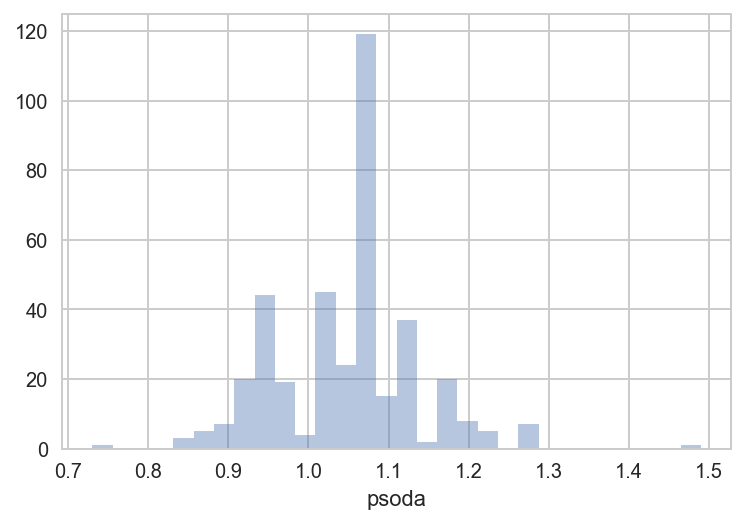

In [17]:
sns.distplot(food.psoda, kde=False, bins=30)

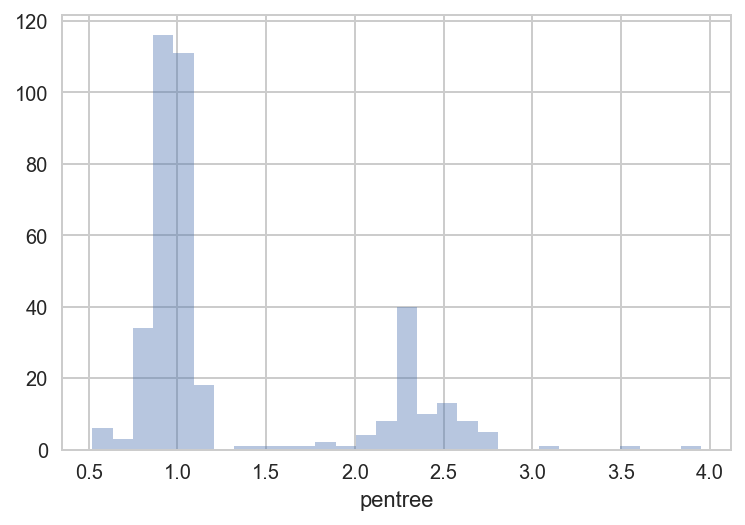

In [18]:
sns.distplot(food.pentree, kde=False, bins=30)

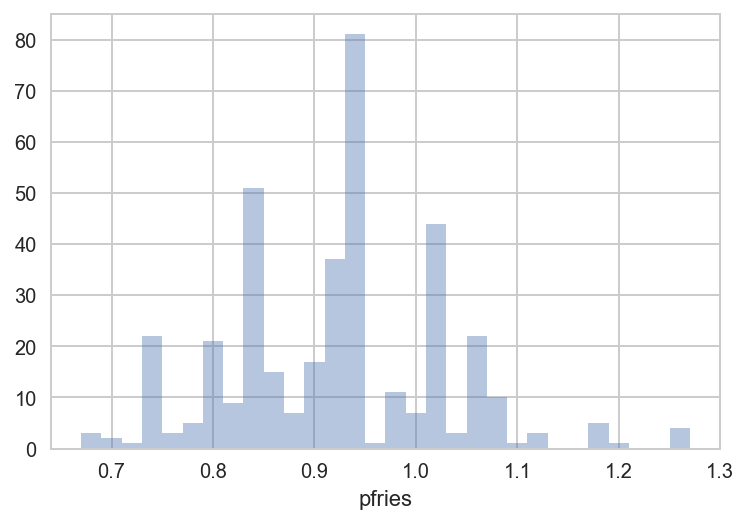

In [19]:
sns.distplot(food.pfries, kde=False, bins=30)

In [20]:
# I assume that prices are correlated between items. Worth a look.
food[['pfries','pentree','psoda']].corr()

,pfries,pentree,psoda
pfries,1.000000,-0.120328,0.669509
pentree,-0.120328,1.000000,-0.092943
psoda,0.669509,-0.092943,1.000000


In [21]:
food.columns

Index(['psoda', 'pfries', 'pentree', 'wagest', 'nmgrs', 'nregs', 'hrsopen',
       'emp', 'compown', 'chain', 'density', 'crmrte', 'state', 'prpblck',
       'prppov', 'prpncar', 'hseval', 'nstores', 'income', 'county', 'NJ',
       'BK', 'KFC', 'RR'],
      dtype='object')

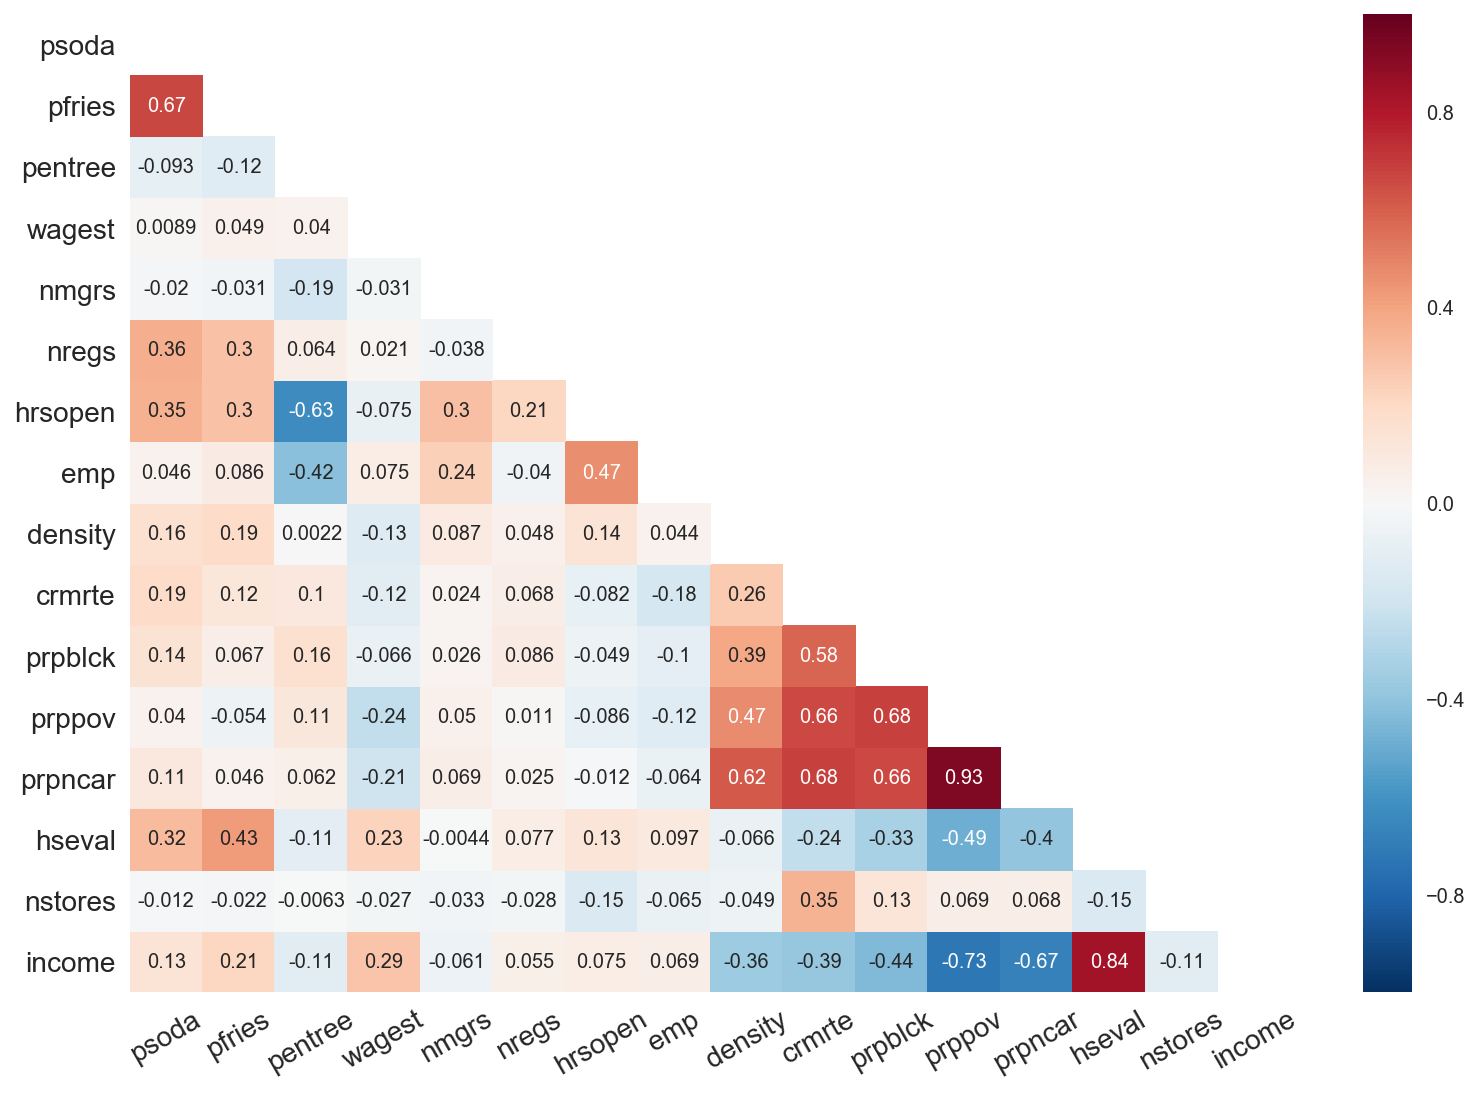

In [22]:
# i'll make a handy correlation matrix heatmap for my (reasonably) continuous measures:

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(13,9))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

continuous = ['psoda','pfries','pentree','wagest','nmgrs','nregs','hrsopen','emp',
              'density','crmrte','prpblck','prppov','prpncar','hseval','nstores',
              'income']
correlation_heat_map(food[continuous])

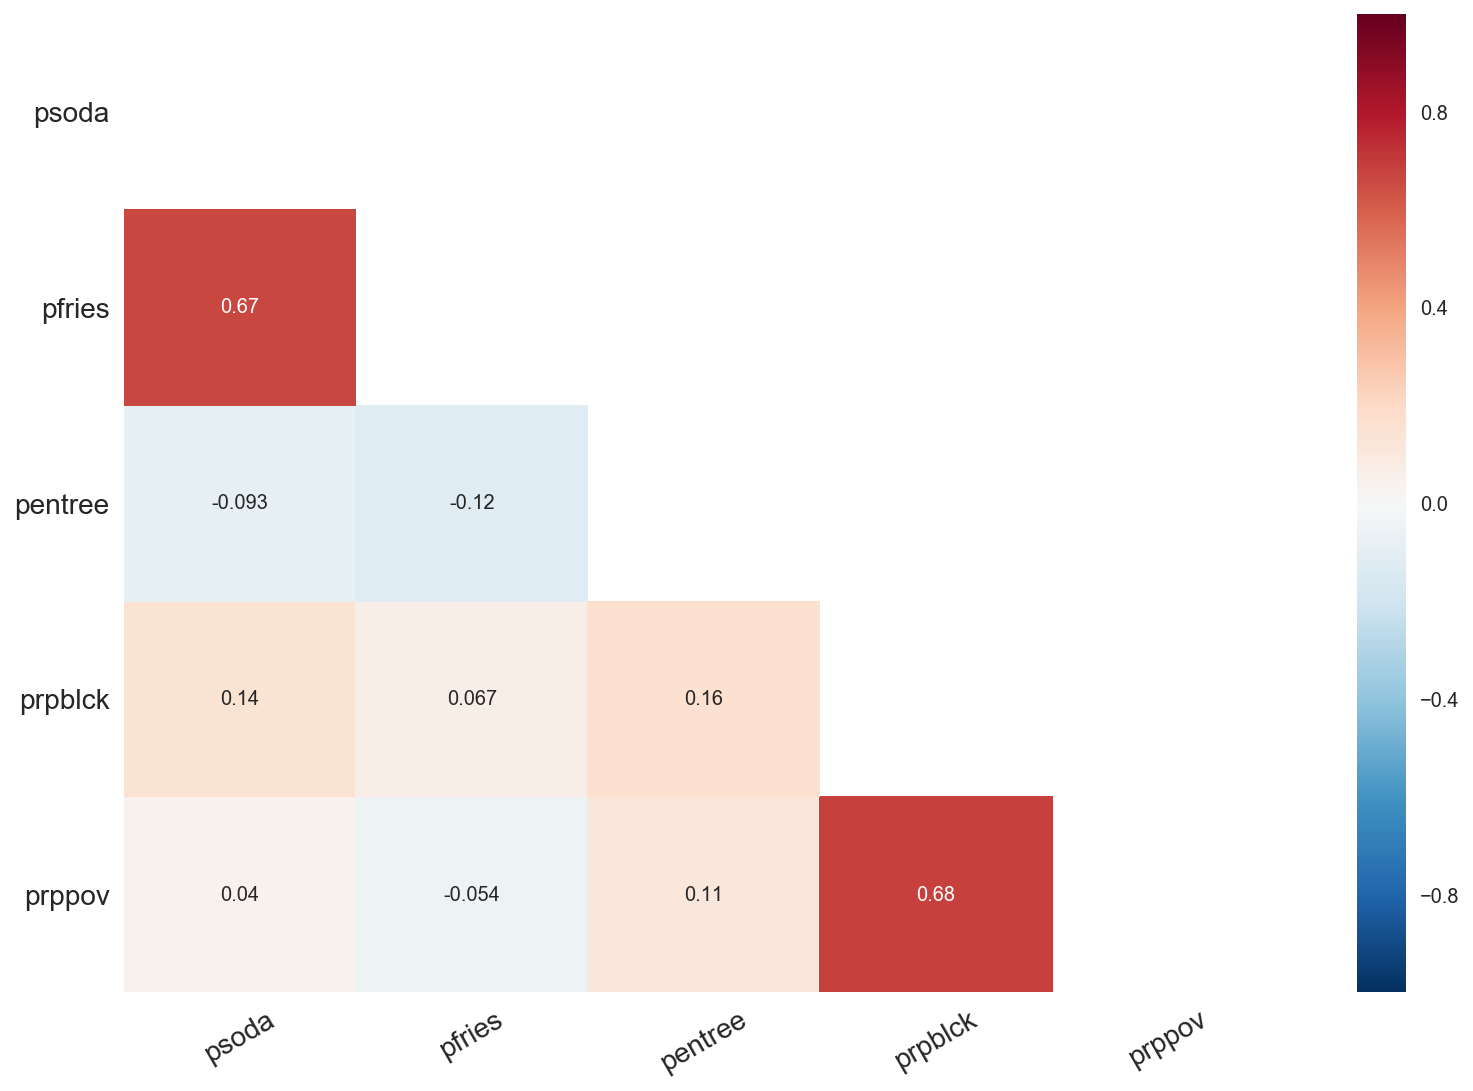

In [23]:
# more specifically the price variables against the proportion black and poor:
correlation_heat_map(food[['psoda','pfries','pentree','prpblck','prppov']])

In [24]:
# take a look at the distributions of proportions

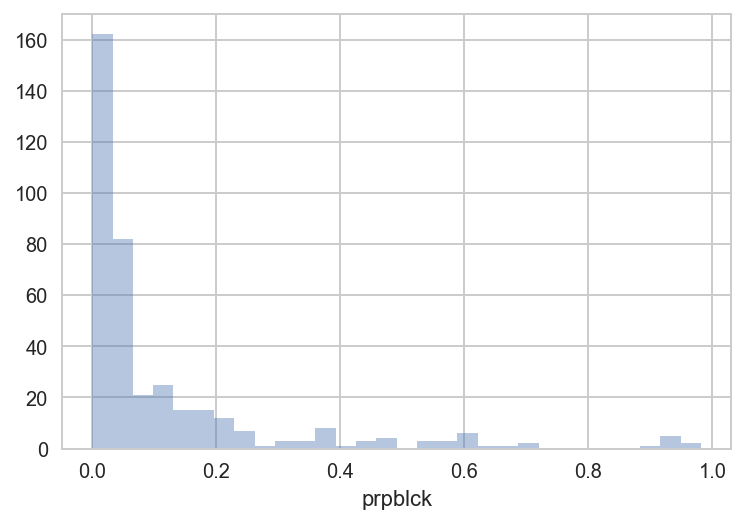

In [25]:
sns.distplot(food.prpblck, kde=False, bins=30)

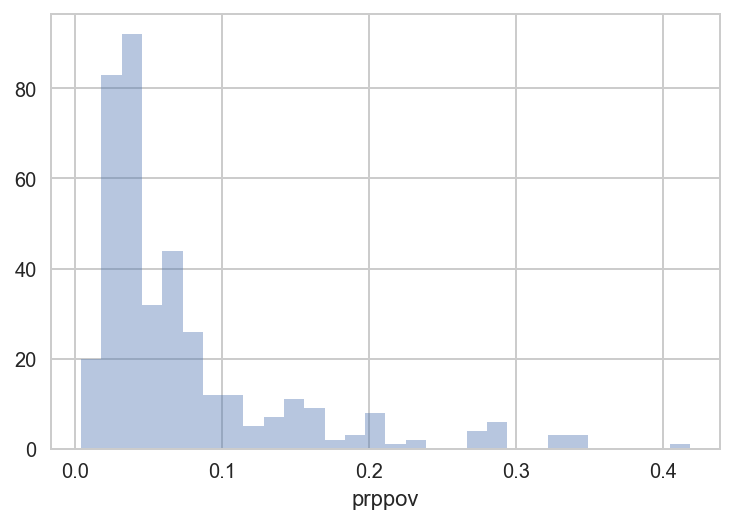

In [26]:
sns.distplot(food.prppov, kde=False, bins=30)

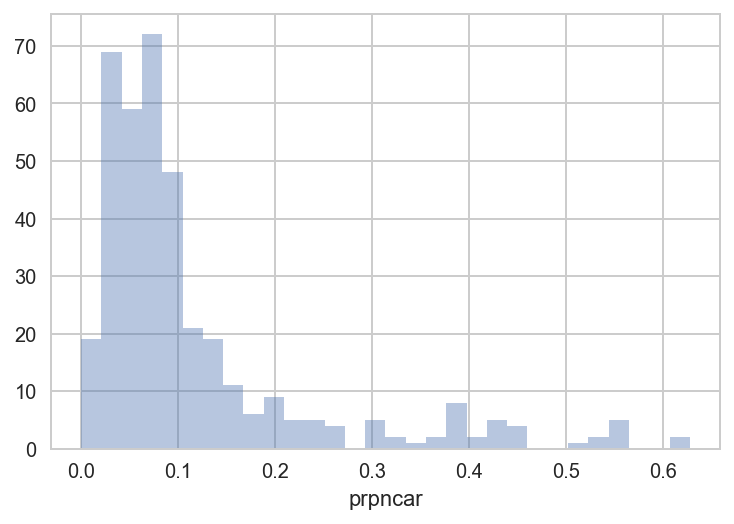

In [27]:
sns.distplot(food.prpncar, kde=False, bins=30)

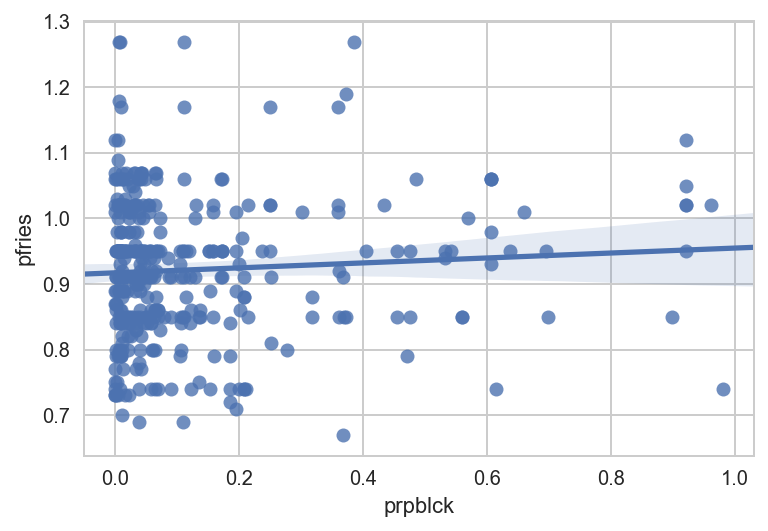

In [28]:
# take a look at price of fries vs. proportion black:
sns.regplot(food.prpblck, food.pfries)

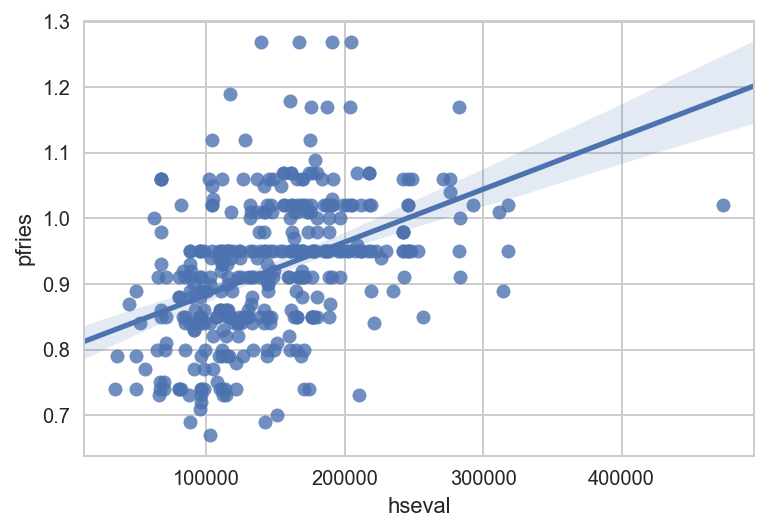

In [29]:
# it looks like there is a strong correlation between price (of fries, at least) and
# median house value
sns.regplot(food.hseval, food.pfries)

In [30]:
# Let's look at the price of fries specifically as our target.
# I want to see if these stores are charging more for fries when the proportion
# of poor people or black people in the area is higher. 

# I could just construct a regression right off the bat predicting price of 
# fries from the proportions, but what if it was other variables that happened
# to be correlated with these predictors that were actually responsible?

# I am first going to predict price of fries from variables that could
# reasonably impact the price:
# 1. The chain
# 3. The wage employees are being paid

# I'll use statsmodels so I can get the summary.

In [31]:
import statsmodels.formula.api as smf


In [32]:
f = 'pfries ~ C(chain) + wagest'
model = smf.ols(f, data=food)
results = model.fit()

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pfries   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     27.97
Date:                Sat, 04 Aug 2018   Prob (F-statistic):           2.21e-20
Time:                        14:34:31   Log-Likelihood:                 370.82
No. Observations:                 386   AIC:                            -731.6
Df Residuals:                     381   BIC:                            -711.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8803      0.066     13.364      0.000       0.751       1.010
C(chain)[T.2]    -0.0546      0.013     -4.238      0.000      -0.080      -0.029
C(chain)[T.3]     0.0843      0.013      6.684      0.000       0.060       0.109
C(chain)[T.4]    -0.0437      0.015     -3.003      0.003      -0.072      -0.015
wagest            0.0087      0.014      0.599      0.550      -0.020       0.037
==============================================================================
Omnibus:                       39.923   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.027
Skew:                           0.619   Prob(JB):                     2.29e-16
Kurtosis:                       4.716   Cond. No.                         67.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# BK = 1, KFC = 2, Roy Rogers = 3, Wendy's = 4
# There is, as should be obvious, a difference in price by chain. 
# Wage however does not impact the price of fries significantly.

In [35]:
# I'm going to extract the residuals out of this model:
resids = results.resid

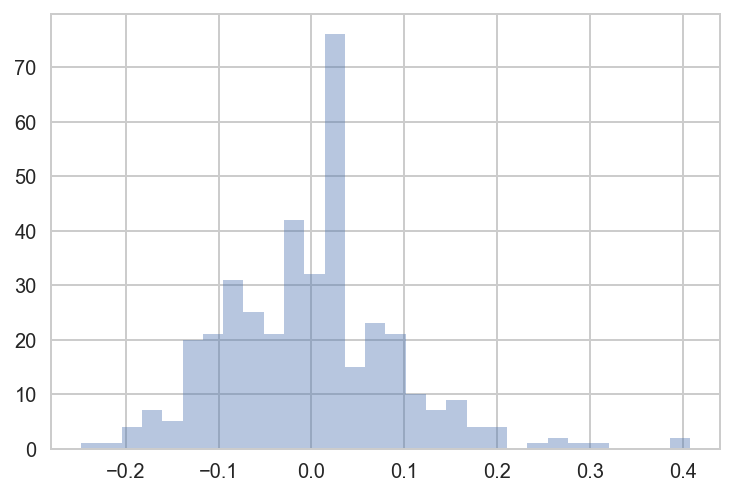

In [36]:
sns.distplot(resids, kde=False, bins=30)

In [37]:
# nice, normally distributed resids. 
# The residuals represent the variance remaining in the price of fries not 
# accounted for by the predictors in my model (at least in a linear sense,
# if there are nonlinear effects the linear regression won't capture them
# adequately.)

# I'm now going to make my target the residuals, and predict those with
# the prpblck and prppov variables. If there are significant effects 
# of these predictors on the residuals then I can be sure that the variance
# they are accounding for is not due to wage or chain.

In [38]:
food['model1_resid'] = resids
model2 = smf.ols('model1_resid ~ prpblck + prppov', data=food)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           model1_resid   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.386
Date:                Sat, 04 Aug 2018   Prob (F-statistic):             0.0349
Time:                        14:34:37   Log-Likelihood:                 374.20
No. Observations:                 386   AIC:                            -742.4
Df Residuals:                     383   BIC:                            -730.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0011      0.007     -0.166      0.869      -0.015       0.012
prpblck        0.0876      0.034      2.549      0.011       0.020       0.155
prppov        -0.1266      0.093     -1.354      0.176      -0.310       0.057
==============================================================================
Omnibus:                       39.372   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.058
Skew:                           0.583   Prob(JB):                     1.85e-17
Kurtosis:                       4.852   Cond. No.                         20.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# I see that the results are significant for the proportion black
# predictor even after controlling for the variance in price accounted
# for by the chain. 

In [63]:
# This is a pretty basic analysis and there is a lot more you could do,
# but should whet your appetite for what is possible!
